In [2]:
import pandas as pd
import numpy as np

#Constants
L1 = 'label_1'
L2 = 'label_2'
L3 = 'label_3'
L4 = 'label_4'
LABELS = [L1, L2, L3, L4]
AGE_LABEL = L2
FEATURES =  [f'feature_{i}' for i in range(1,769)]

In [3]:
train_df = pd.read_csv("train_9.csv")
valid_df = pd.read_csv("valid_9.csv")
test_df = pd.read_csv("test_9.csv")

In [4]:
from pandas.core.arrays.period import validate_dtype_freq
# Scaling the data
from sklearn.preprocessing import RobustScaler # RobustScaler

x_train = {}
x_valid = {}
x_test = {}
y_train = {}
y_valid = {}

for target_label in LABELS:
  tr_df = train_df[train_df['label_2'].notna()] if target_label == 'label_2' else train_df # remove NA values in label 2
  vl_df = valid_df[valid_df['label_2'].notna()] if target_label == 'label_2' else valid_df
  t_df = test_df
  scaler = RobustScaler()
  x_train[target_label] = pd.DataFrame(scaler.fit_transform(tr_df.drop(LABELS, axis=1)), columns = FEATURES)
  x_test[target_label] = pd.DataFrame(scaler.fit_transform(t_df.drop("ID", axis=1)), columns = FEATURES)
  y_train[target_label] = tr_df[target_label]
  x_valid[target_label] = pd.DataFrame(scaler.transform(vl_df.drop(LABELS, axis=1)), columns = FEATURES)
  y_valid[target_label] = vl_df[target_label]

In [5]:
print(x_test)

{'label_1':      feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0     0.465731   1.014872  -0.360705   0.204573   0.441294   0.176590   
1     0.347988   1.152174  -0.694119   0.106543   0.601438   0.025268   
2    -0.851793   0.082824  -1.150472   0.732961  -0.075655  -0.030616   
3     0.157516  -0.238740  -0.193648   0.284084   0.368908  -1.341268   
4    -1.001883  -0.231752  -0.668922   0.255354   0.362047   1.094476   
..         ...        ...        ...        ...        ...        ...   
739  -0.436024   0.938412   0.784822   0.437669  -0.605967   0.320408   
740  -1.045213  -0.650795   0.597343  -0.259471   1.003291   0.432694   
741  -0.363975  -0.771116  -0.158626  -0.540375   0.629514   0.879441   
742  -0.073609  -0.357714   0.411233  -0.580633   0.208073   0.172877   
743   0.173445   0.923834   0.320277  -0.437994   0.479609   0.701310   

     feature_7  feature_8  feature_9  feature_10  ...  feature_759  \
0    -1.003111  -0.444207  -0.368492    0

**Model Training Function**

In [15]:
from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

def classificationModelsAccuracy(model, x_train, y_train, x_valid, y_valid):
  models = ['svm', 'xgboost']
  created_model = 0
  if 'svm' == model:
    created_model = svm.SVC(kernel='linear', class_weight='balanced')
    created_model.fit(x_train, y_train)
    y_pred = created_model.predict(x_valid)
    print('SVM accuracy Score :', metrics.accuracy_score(y_valid, y_pred))
  elif 'randomForest' == model:
    created_model = RandomForestClassifier(n_estimators=100, random_state=42)
    created_model.fit(x_train, y_train)
    y_pred = created_model.predict(x_valid)
    print('Random Forest accuracy :', metrics.accuracy_score(y_valid, y_pred))
  return created_model

--------------------------------------

In [7]:
svm = classificationModelsAccuracy('svm', x_train[L1], y_train[L1], x_valid[L1], y_valid[L1])

SVM accuracy Score : 0.9613333333333334


In [6]:
random_forest = classificationModelsAccuracy('randomForest', x_train[L1], y_train[L1], x_valid[L1], y_valid[L1])

Random Forest accuracy : 0.8533333333333334


**Feature Reduction**

Select K-Best

In [8]:
from sklearn.feature_selection import SelectKBest, f_classif

def selectKBestFunction(x_train, y_train, x_valid, x_test, k):
  selector = SelectKBest(score_func=f_classif, k=k)
  x_new_train = selector.fit_transform(x_train, y_train)
  x_new_valid = selector.transform(x_valid)
  x_new_test = selector.transform(x_test)
  return x_new_train, x_new_valid, x_new_test

PCA

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def PCAFunction(L, xTrain, xValid, xTest, n):
    scaler = StandardScaler()

    # Standardize the data
    x_train_scaled = pd.DataFrame(scaler.fit_transform(xTrain), columns=xTrain.columns)
    x_valid_scaled = pd.DataFrame(scaler.transform(xValid), columns=xValid.columns)
    x_test_scaled = pd.DataFrame(scaler.transform(xTest), columns=xTest.columns)

    pca = PCA(n_components=n, svd_solver='full')
    pca.fit(x_train_scaled)
    # Transform the data and convert the result to DataFrames
    x_pca_train = pd.DataFrame(pca.transform(x_train_scaled))
    x_pca_valid = pd.DataFrame(pca.transform(x_valid_scaled))
    x_pca_test = pd.DataFrame(pca.transform(x_test_scaled))

    return x_pca_train, x_pca_valid, x_pca_test


**Hyper Parameter Tuning**

Random Search

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [11]:
def randomSearch(model, xTrain, yTrain, L):
  param_dist = {
    'C': uniform(0.1, 10),          # Continuous distribution for 'C'
    'kernel': ['linear', 'rbf'],    # List of choices for 'kernel'
    'gamma': uniform(0.001, 1.0)   # Continuous distribution for 'gamma'
  }
  random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=5,     # Number of random combinations to try
    cv=2,           # Number of cross-validation folds
    n_jobs=-1,     # Use all available CPU cores
    random_state=42
  )

  random_search.fit(xTrain, yTrain)
  best_params = random_search.best_params_
  best_model = random_search.best_estimator_
  return best_model

**Cross Validation**

In [12]:
from sklearn.model_selection import cross_val_score

def crossValidationFunction(model, x_train, y_train, k):
    scores = cross_val_score(model, x_train, y_train, cv=k)
    print("Cross-validation scores: ", scores)
    print("%0.2f accuracy with a standard deviation of %f" % (scores.mean(), scores.std()))

**For Label 1**

c:\Users\Jalitha Kalsara\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Jalitha Kalsara\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Jalitha Kalsara\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='label_1', ylabel='count'>

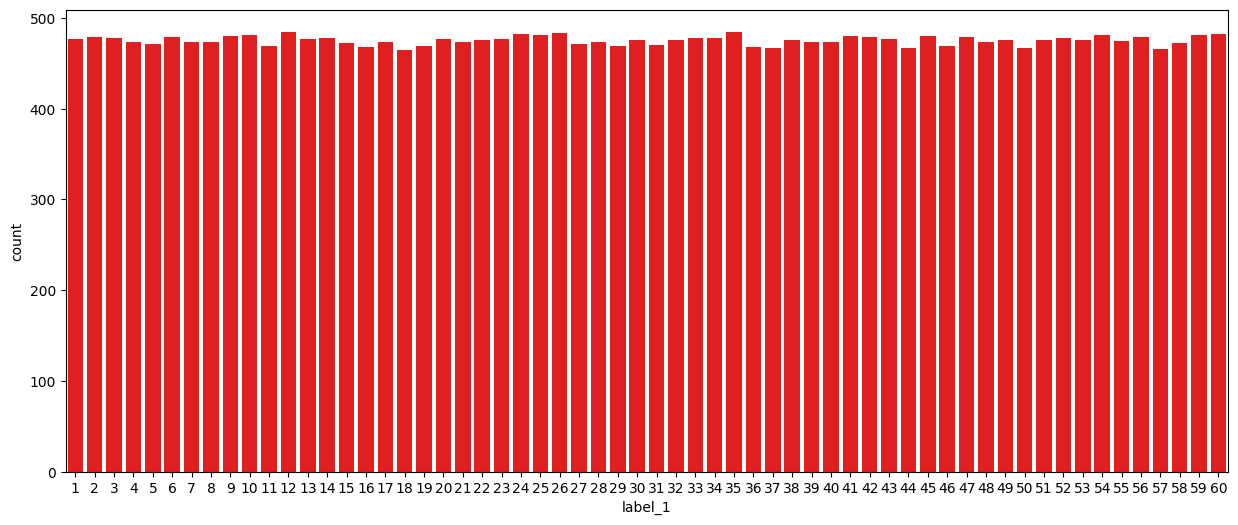

In [13]:
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(15,6))
sn.countplot(data=y_train, x=L1, color='red')

In [16]:
# without feature engineering
svm = classificationModelsAccuracy('svm', x_train[L1], y_train[L1], x_valid[L1], y_valid[L1])

SVM accuracy Score : 0.9613333333333334


In [18]:
y_pred_val_label1 = svm.predict(x_valid[L1])
print(y_pred_val_label1.shape)
print(y_valid[L4].shape)
print('SVM accuracy Score :', metrics.accuracy_score(y_valid[L1], y_pred_val_label1))

(750,)
(750,)
SVM accuracy Score : 0.9613333333333334


In [19]:
import csv

array = y_pred_val_label1

# Define the number of rows (assuming all arrays have the same length)
num_rows = len(y_pred_val_label1)

# Create and open a CSV file for writing
with open('layer_9_label_1.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write data rows
    for i in range(num_rows):
        row = [array[i]]
        writer.writerow(row)

print("CSV file 'layer_9_label_1.csv' has been created.")

CSV file 'layer_9_label_1.csv' has been created.


Applying PCA

In [59]:
# Applying PCA
x_pca_train1, x_pca_valid1, x_pca_test1 = PCAFunction(L1, x_train[L1], x_valid[L1], x_test[L1], 0.95)

In [60]:
x_pca_train1.shape
x_pca_valid1.shape
x_pca_test1.shape

(744, 310)

In [61]:
from sklearn.svm import SVC

svm_classifier = SVC()
tuned_model1 = randomSearch(svm_classifier, x_pca_train1, y_train[L1], L1)

In [62]:

y_pred1 = tuned_model1.predict(x_pca_valid1)
print(y_pred1.shape)
print(y_valid[L1].shape)
print('After Random Search using SVM accuracy Score :', metrics.accuracy_score(y_valid[L1], y_pred1))

(750,)
(750,)
After Random Search using SVM accuracy Score : 0.9573333333333334


Applying K-Best

In [88]:
# Applying selectKBest
x_training_label1, x_valid_label1, x_test_label1 = selectKBestFunction(x_train[L1], y_train[L1], x_valid[L1],x_test[L1], 500)

In [64]:
from sklearn.svm import SVC

svm_classifier = SVC()
tuned_model1_2 = randomSearch(svm_classifier, x_training_label1, y_train[L1], L1)

In [65]:
y_pred = tuned_model1_2.predict(x_valid_label1)
print(y_pred.shape)
print(y_valid[L1].shape)
print('After Random Search using SVM accuracy Score :', metrics.accuracy_score(y_valid[L1], y_pred))

(750,)
(750,)
After Random Search using SVM accuracy Score : 0.9613333333333334


In [104]:
# cross validation
crossValidationFunction(tuned_model1_2, x_training_label1, y_train[L1], 3)

Cross-validation scores: [0.95003681 0.94772273 0.95097833]
0.95 accuracy with a standard deviation of 0.00


**For Label 2**

c:\Users\Jalitha Kalsara\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Jalitha Kalsara\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Jalitha Kalsara\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='label_2', ylabel='count'>

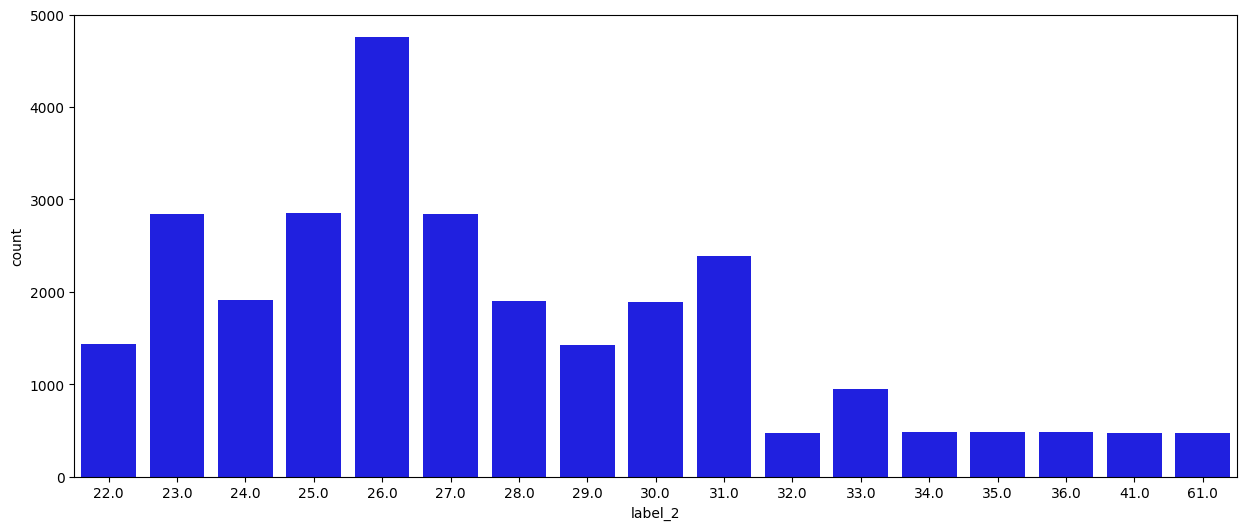

In [20]:
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(15,6))
sn.countplot(data=y_train, x=L2, color='blue')

In [27]:
# Without feature engineering
svm = classificationModelsAccuracy('svm', x_train[L2], y_train[L2], x_valid[L2], y_valid[L2])

SVM accuracy Score : 0.8206521739130435


Applying PCA

In [129]:
# Applying PCA
x_pca_train2, x_pca_valid2, x_pca_test2 = PCAFunction(L2, x_train[L2], x_valid[L2], x_test[L2], 0.97)

In [130]:
x_pca_train2.shape


(28040, 401)

In [131]:
from sklearn.svm import SVC

svm_classifier = SVC(class_weight='balanced')
tuned_model2 = randomSearch(svm_classifier, x_pca_train2, y_train[L2], L2)

In [123]:
y_pred = tuned_model2.predict(x_pca_valid2)
print(y_pred.shape)
print(y_valid[L2].shape)
print('After Random Search using SVM accuracy Score :', metrics.accuracy_score(y_valid[L2], y_pred))

(736,)
(736,)
After Random Search using SVM accuracy Score : 0.7635869565217391


Applying K-Best

In [21]:
x_training_label2, x_valid_label2, x_test_label2 = selectKBestFunction(x_train[L2], y_train[L2], x_valid[L2], x_test[L2], 500)

In [22]:
from sklearn.svm import SVC

svm_classifier = SVC(class_weight='balanced')
tuned_model2_2 = randomSearch(svm_classifier, x_training_label2, y_train[L2], L2)

In [23]:
y_pred_val_label2 = tuned_model2_2.predict(x_valid_label2)
print(y_pred_val_label2.shape)
print(y_valid[L2].shape)
print('After Random Search using SVM accuracy Score :', metrics.accuracy_score(y_valid[L2], y_pred_val_label2))

(736,)
(736,)
After Random Search using SVM accuracy Score : 0.7663043478260869


In [24]:
import csv

array = y_pred_val_label2

# Define the number of rows (assuming all arrays have the same length)
num_rows = len(y_pred_val_label2)

# Create and open a CSV file for writing
with open('layer_9_label_2.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write data rows
    for i in range(num_rows):
        row = [array[i]]
        writer.writerow(row)

print("CSV file 'layer_9_label_2.csv' has been created.")

CSV file 'layer_9_label_2.csv' has been created.


**For Label 3**

c:\Users\Jalitha Kalsara\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Jalitha Kalsara\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Jalitha Kalsara\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='label_3', ylabel='count'>

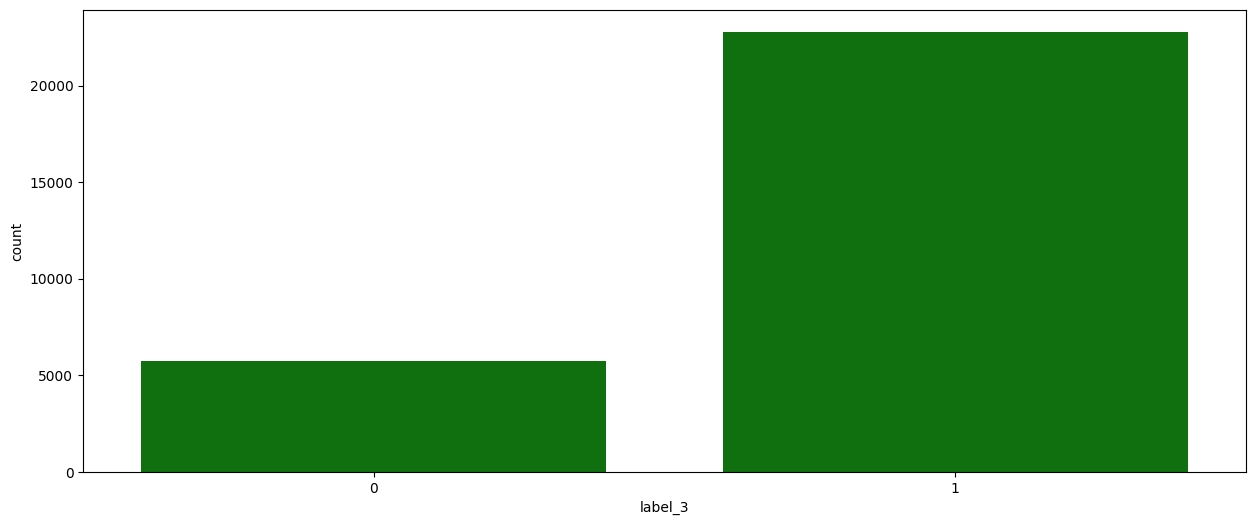

In [25]:
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(15,6))
sn.countplot(data=y_train, x=L3, color='green')

In [33]:
svm = classificationModelsAccuracy('svm', x_train[L3], y_train[L3], x_valid[L3], y_valid[L3])

SVM accuracy Score : 0.9933333333333333


Applying PCA

In [26]:
# Applying PCA
x_pca_train3, x_pca_valid3, x_pca_test3 = PCAFunction(L3, x_train[L3], x_valid[L3], x_test[L3], 0.95)

In [27]:
x_pca_train3.shape

(28520, 310)

In [28]:
from sklearn.svm import SVC

svm_classifier = SVC()
tuned_model3 = randomSearch(svm_classifier, x_pca_train3, y_train[L3], L3)

In [29]:
y_pred_val_label3 = tuned_model3.predict(x_pca_valid3)
print(y_pred_val_label3.shape)
print(y_valid[L3].shape)
print('After Random Search using SVM accuracy Score :', metrics.accuracy_score(y_valid[L3], y_pred_val_label3))

(750,)
(750,)
After Random Search using SVM accuracy Score : 0.9893333333333333


In [30]:
import csv

array = y_pred_val_label3

# Define the number of rows (assuming all arrays have the same length)
num_rows = len(y_pred_val_label3)

# Create and open a CSV file for writing
with open('layer_9_label_3.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write data rows
    for i in range(num_rows):
        row = [array[i]]
        writer.writerow(row)

print("CSV file 'layer_9_label_3.csv' has been created.")

CSV file 'layer_9_label_3.csv' has been created.


In [132]:
#cross validation
crossValidationFunction(tuned_model3, x_pca_train3, y_train[L3], 3)

Cross-validation scores:  [0.97685916 0.98895551 0.9647591 ]
0.98 accuracy with a standard deviation of 0.009878


Applying K-Best

In [94]:
x_training_label3, x_valid_label3, x_test_label3 = selectKBestFunction(x_train[L3], y_train[L3], x_valid[L3], x_test[L3], 500)

In [78]:
from sklearn.svm import SVC

svm_classifier = SVC(class_weight='balanced')
tuned_model3_2 = randomSearch(svm_classifier, x_training_label3, y_train[L3], L3)

In [79]:
y_pred = tuned_model3_2.predict(x_valid_label3)
print(y_pred.shape)
print(y_valid[L3].shape)
print('After Random Search using SVM accuracy Score :', metrics.accuracy_score(y_valid[L3], y_pred))

(750,)
(750,)
After Random Search using SVM accuracy Score : 0.996


**For Label 4**

c:\Users\Jalitha Kalsara\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Jalitha Kalsara\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Jalitha Kalsara\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='label_4', ylabel='count'>

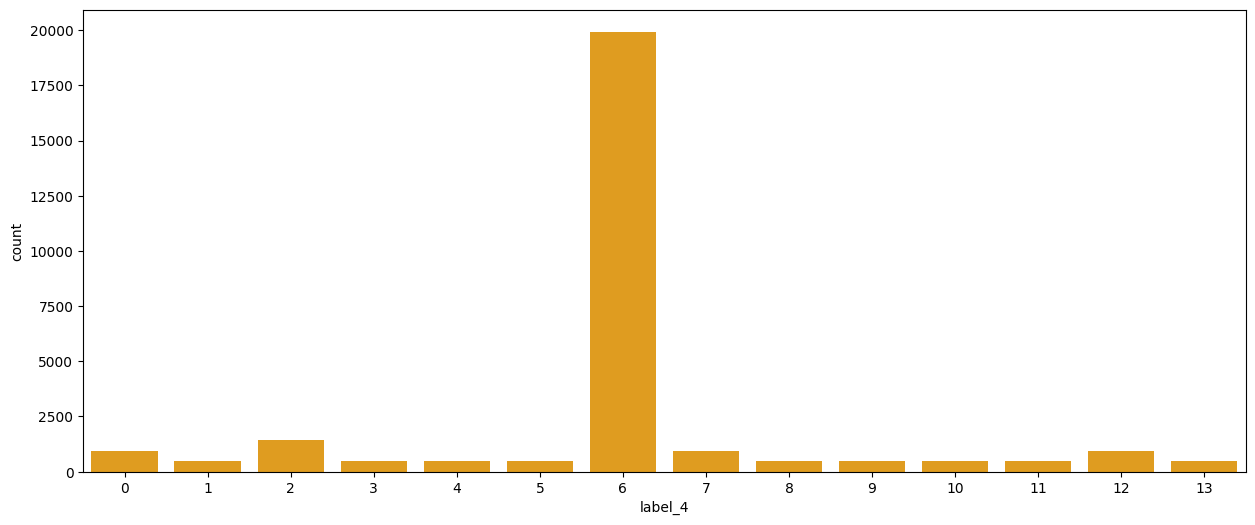

In [38]:
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(15,6))
sn.countplot(data=y_train, x=L4, color='orange')

In [41]:
svm = classificationModelsAccuracy('svm', x_train[L4], y_train[L4], x_valid[L4], y_valid[L4])

SVM accuracy Score : 0.9426666666666667


Applying PCA

In [31]:
# Applying PCA
x_pca_train4, x_pca_valid4, x_pca_test4 = PCAFunction(L4, x_train[L4], x_valid[L4], x_test[L4], 0.95)

In [32]:
x_pca_train4.shape

(28520, 310)

In [33]:
from sklearn.svm import SVC

svm_classifier = SVC()
tuned_model4 = randomSearch(svm_classifier, x_pca_train4, y_train[L4], L4)

In [34]:
y_pred_val_label4 = tuned_model4.predict(x_pca_valid4)
print(y_pred_val_label4.shape)
print(y_valid[L4].shape)
print('After Random Search using SVM accuracy Score :', metrics.accuracy_score(y_valid[L4], y_pred_val_label4))

(750,)
(750,)
After Random Search using SVM accuracy Score : 0.9106666666666666


In [35]:
import csv

array = y_pred_val_label4

# Define the number of rows (assuming all arrays have the same length)
num_rows = len(y_pred_val_label4)

# Create and open a CSV file for writing
with open('layer_9_label_4.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write data rows
    for i in range(num_rows):
        row = [array[i]]
        writer.writerow(row)

print("CSV file 'layer_9_label_4.csv' has been created.")

CSV file 'layer_9_label_4.csv' has been created.


In [133]:
#cross validation
crossValidationFunction(tuned_model4, x_pca_train4, y_train[L4], 3)

Cross-validation scores:  [0.90312401 0.90428106 0.88985904]
0.90 accuracy with a standard deviation of 0.006543


Applying K-Best

In [95]:
x_training_label4, x_valid_label4, x_test_label4 = selectKBestFunction(x_train[L4], y_train[L4], x_valid[L4],x_test[L4], 500)

In [85]:
from sklearn.svm import SVC

svm_classifier = SVC(class_weight='balanced')
tuned_model4_2 = randomSearch(svm_classifier, x_training_label4, y_train[L4], L4)

In [86]:
y_pred = tuned_model4_2.predict(x_valid_label4)
print(y_pred.shape)
print(y_valid[L4].shape)
print('After Random Search using SVM accuracy Score :', metrics.accuracy_score(y_valid[L4], y_pred))

(750,)
(750,)
After Random Search using SVM accuracy Score : 0.9666666666666667


**Predicting the test data**

Label 1

In [89]:
y_pred_label1 = tuned_model1_2.predict(x_test_label1)

In [101]:
type(y_pred_label1)

numpy.ndarray

Label 2

In [96]:
y_pred_label2 = tuned_model2.predict(x_pca_test2)

Label 3

In [99]:
y_pred_label3 = tuned_model3.predict(x_pca_test3)

Label 4

In [100]:
y_pred_label4 = tuned_model4.predict(x_pca_test4)

Creating CSV file

In [102]:
import csv
import numpy as np

# Create your NumPy arrays (replace these with your actual data)
array1 = y_pred_label1
array2 = y_pred_label2
array3 = y_pred_label3
array4 = y_pred_label4

# Define the number of rows (assuming all arrays have the same length)
num_rows = len(array1)

# Create and open a CSV file for writing
with open('output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row
    header = ["ID", "label_1", "label_2", "label_3", "label_4"]
    writer.writerow(header)
    
    # Write data rows
    for i in range(num_rows):
        row = [i+1, array1[i], array2[i], array3[i], array4[i]]
        writer.writerow(row)

print("CSV file 'output.csv' has been created.")


CSV file 'output.csv' has been created.
